In [1]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import glob

In [2]:
# loadmat aux function to load the matlab save files
# from: https://stackoverflow.com/review/suggested-edits/21667510

import numpy as np
import scipy
import scipy.io as spio

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], spio.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _has_struct(elem):
        """Determine if elem is an array and if any array item is a struct"""
        return isinstance(elem, np.ndarray) and any(isinstance(
                    e, scipy.io.matlab.mio5_params.mat_struct) for e in elem)

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, spio.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif _has_struct(elem):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, spio.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif _has_struct(sub_elem):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = scipy.io.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

In [3]:
# Matlab code conversion

# Read matlab file instead of excelfile (easier conversion)
data = loadmat('matlab.mat')

C:\Users\camar\AppData\Local\Temp\ipykernel_21920\2531193362.py:21: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  if isinstance(d[key], spio.matlab.mio5_params.mat_struct):
C:\Users\camar\AppData\Local\Temp\ipykernel_21920\2531193362.py:37: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  if isinstance(elem, spio.matlab.mio5_params.mat_struct):
C:\Users\camar\AppData\Local\Temp\ipykernel_21920\2531193362.py:28: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  e, scipy.io.matlab.mio5_params.mat_struct) for e in elem)


In [4]:
# Linearize the generator prices

# genCofA=data.generator.limit(:,:,6); -> MATLAB starts with 1, so we need the index -1
# genCofB=data.generator.limit(:,:,7);
# genCofC=data.generator.limit(:,:,8);

genCofA = data['data']['generator']['limit'][:, :, 5]
genCofB = data['data']['generator']['limit'][:, :, 6]
genCofC = data['data']['generator']['limit'][:, :, 7]

In [5]:
# Options for simulation

#options 
iterlim = 1000000000
reslim = 5000000000

In [6]:
# Definir o numero de resources usados

numGen = np.arange(1, data['data']['parameterData']['resources']['numGen'] + 1)
numLoad = np.arange(1, data['data']['parameterData']['resources']['numLoad'] + 1)
numStor = np.arange(1, data['data']['parameterData']['resources']['numStor'] + 1)
numV2G = np.arange(1, data['data']['parameterData']['resources']['numV2G'] + 1)
numCStat = np.arange(1, data['data']['parameterData']['resources']['numCStat'] + 1)
numPeriod = np.arange(1, data['data']['parameterData']['resources']['period'] + 1)
numBus = np.array([1]) #np.arange(1) # forced to 1
nOwner = np.arange(1, data['data']['parameterData']['resources']['owners'] + 1)

In [7]:
# Define as strings com os recursos para mandar para GAMS

gen = np.max(numGen)
Load = np.max(numLoad)
stor = np.max(numStor)
v2g = np.max(numV2G)
cs = np.max(numCStat)
period = np.max(numPeriod)
Bus = np.max(numBus)

In [8]:
#% Definir as matrizes com os dados para o GAMS

# General Info
pMaxImp = data['data']['parameterData']['generalInfo']['P_Max_Imp']
pMaxExp = data['data']['parameterData']['generalInfo']['P_Max_Exp']
buyPrice = data['data']['parameterData']['generalInfo']['Energy_Buy_Price']
sellPrice = data['data']['parameterData']['generalInfo']['Energy_Sell_Price']

# Geradores
genLimit = data['data']['generator']['limit'][numGen[0]-1:numGen[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]
genInfo = data['data']['generator']['info']

# Cargas
loadLimit = data['data']['load']['limit'][numLoad[0]-1:numLoad[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]

# Baterias
storLimit = data['data']['storage']['limit'][numStor[0]-1:numStor[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]
storInfo = data['data']['storage']['info']

# Veiculos
v2gLimit = data['data']['vehicle']['limit']
v2gInfo = data['data']['vehicle']['info']

# Charging Station
csLimit = data['data']['cstation']['limit'][numCStat[0]-1:numCStat[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]
csInfo = data['data']['cstation']['info']

# Connect EV to Charging Station
EV_CS_Info = data['data']['vehicle']['timeInfo']['V2GinCS']

In [9]:
# Definir os dados da rede para o GAMS

# Linhas
branchData = data['data']['network']['branch']

# Tensão Máxima
voltageMax = data['data']['parameterData']['network']['voltageMax']

# Tensão Mínima
voltageMin = data['data']['parameterData']['network']['voltageMin']

# Angulo Máximo
angleMax = data['data']['parameterData']['network']['angleMax']

# Angulo Mínimo
angleMin = data['data']['parameterData']['network']['angleMin']

# Definir a matriz das admitancias
ybus = data['data']['parameterData']['network']['ybus']
diag = data['data']['parameterData']['network']['diag']
branchID = data['data']['parameterData']['network']['branch']

In [10]:
#% Anular o custo fixo e quadratico da DG

genLimit[:, :, 3] = 0
genLimit[:, :, 5] = 0

genLimit = np.append(genLimit, np.zeros(shape=(7, 24, 4)), axis=2)

# Not necessary anymore
#genLimit[:, :, 9] = 0
#genLimit[:, :, 11] = 0

In [11]:
# Define the fixed sets structure to use in the parameters of the gams optimization process

NCOLS = 12

genLimitInfo = np.arange(1, NCOLS+1)
loadLimitInfo = np.arange(1, NCOLS+1)
storLimitInfo = np.arange(1, NCOLS+1)
v2gLimitInfo = np.arange(1, NCOLS+1)
csLimitInfo = np.arange(1, NCOLS+1)

In [12]:
# Define the several sets structure used in the gams optimization process, 
# these sets depends the number of resources used in matlab code

_t = np.arange(period)
_gen = np.arange(gen)
_Load = np.arange(Load)
_stor = np.arange(stor)
_v2g = np.arange(v2g)
_cs = np.arange(cs)

In [13]:
# Positive variables

genActPower = np.ones(shape=(len(_gen), len(_t)))
genExcActPower = np.ones(shape=(len(_gen), len(_t)))
pImp = np.ones(shape=(len(_t)))
pExp = np.ones(shape=(len(_t)))

# Load variables
loadRedActPower = np.ones(shape=(len(_Load), len(_t)))
loadCutActPower = np.ones(shape=(len(_Load), len(_t)))
loadENS = np.ones(shape=(len(_Load), len(_t)))

# Storage variables
storDchActPower = np.ones(shape=(len(_stor), len(_t)))
storChActPower = np.ones(shape=(len(_stor), len(_t)))
storEminRelaxStor = np.ones(shape=(len(_stor), len(_t)))
storEnerState = np.ones(shape=(len(_stor), len(_t)))

# V2G variables
v2gDchActPower = np.ones(shape=(len(_v2g), len(_t)))
v2gChActPower = np.ones(shape=(len(_v2g), len(_t)))
v2gEnerState = np.ones(shape=(len(_v2g), len(_t)))
v2gEminRelaxEv = np.ones(shape=(len(_v2g), len(_t)))

# Charging Stations
csActPower = np.ones(shape=(len(_cs), len(_t)))
csActPowerNet = np.ones(shape=(len(_cs), len(_t)))

# Storage deg
storSegSoC = np.ones(shape=(len(_stor), len(_t), 3))
v2gSegSoC = np.ones(shape=(len(_v2g), len(_t), 3))

In [14]:
# Binary variables

genXo = np.zeros(shape=(len(_gen), len(_t)))
loadXo = np.zeros(shape=(len(_Load), len(_t)))

storChXo = np.zeros(shape=(len(_stor), len(_t)))
storDchXo = np.zeros(shape=(len(_stor), len(_t)))

v2gChXo = np.zeros(shape=(len(_v2g), len(_t)))
v2gDchXo = np.zeros(shape=(len(_v2g), len(_t)))

# Battery deg binary variables
storSegXo = np.zeros(shape=(len(_stor), len(_t), 3))
v2gSegXo = np.zeros(shape=(len(_v2g), len(_t), 3))

In [15]:
# Turn and recover vector for encoding

def encode(var_dictionary):
    result_concat = np.concatenate([var_dictionary[v].ravel() for v in var_dictionary.keys()])
    return result_concat


def decode(var_vector, var_dictionary):
    result_decoded = {}
    var_idx = [var_dictionary[v].ravel().shape[0] for v in var_dictionary.keys()]

    current_index = 0
    dictionary_names = list(var_dictionary.keys())
    
    for idx in np.arange(len(dictionary_names)):
        result_index = current_index + var_idx[idx]
        result_decoded[dictionary_names[idx]] = np.reshape(var_vector[current_index:result_index], 
                                                           var_dictionary[dictionary_names[idx]].shape)
        
        current_index = result_index
        
    return result_decoded

In [16]:
# Define dictionaries

dict_var = {'genActPower': genActPower,
            'genExcActPower': genExcActPower,
            'pImp': pImp,
            'pExp': pExp,
            'loadRedActPower': loadRedActPower,
            'loadCutActPower': loadCutActPower,
            'loadENS': loadENS,
            'storDchActPower': storDchActPower,
            'storChActPower': storChActPower,
            'EminRelaxStor': storEminRelaxStor,
            'storEnerState': storEnerState,
            'v2gDchActPower': v2gDchActPower,
            'v2gChActPower': v2gChActPower,
            'EminRelaxEV': v2gEminRelaxEv,
            'v2gEnerState': v2gEnerState,
            'csActPower': csActPower,
            'csActPowerNet': csActPowerNet,
            'genXo': genXo,
            'loadXo': loadXo,
            'storDchXo': storDchXo,
            'storChXo': storChXo,
            'v2gDchXo': v2gDchXo,
            'v2gChXo': v2gChXo}#,
            #'storSegSoC': storSegSoC,
            #'v2gSegSoC': v2gSegSoC,
            #'storSegXo': storSegXo,
            #'v2gSegXo': v2gSegXo}
encoded_vars = encode(dict_var)
encoded_vars = encoded_vars.astype(float)
decoded_vars = decode(encoded_vars, dict_var)

dict_par = {'genLimit': genLimit,
            'genInfo': genInfo,
            'pImpMax': pMaxImp,
            'pExpMax': pMaxExp,
            'loadLimit': loadLimit,
            'loadActPower': loadLimit[:, :, 0],
            'storLimit': storLimit,
            'storInfo': storInfo[:, :12],
            'v2gLimit': v2gLimit,
            'v2gInfo': v2gInfo,
            'csLimit': csLimit,
            'csInfo': csInfo,
            'EV_CS_Info': EV_CS_Info,
            'buyPrice': buyPrice,
            'sellPrice': sellPrice,
            't': _t,
            'gen': _gen,
            'load': _Load,
            'stor': _stor,
            'v2g': _v2g,
            'cs': _cs,
            #'storPieceSegments': np.array([1, 2, 3]),
            'storCapCost': storInfo[:, 5] * 0.00105,
            #'storCyclesMult': np.array([1000, 1200, 700]),
            'v2gCapCost': v2gInfo[:, 4] * 0.00105}
            #'v2gCyclesMult': np.array([1000, 1000, 1000, 1000, 1000])}
encoded_pars = encode(dict_par)
encoded_pars = encoded_pars.astype(float)
decoded_pars = decode(encoded_pars, dict_par)

In [17]:
# Encoded and decoded dictionaries

encoded_dict = encode(dict_var)

decoded_dict = decode(encoded_dict, dict_var)

In [18]:
# Define min and max values allowed

minVals = {'genActPower': np.array(np.zeros((1, genActPower.ravel().shape[0]))),
           'genExcActPower': np.array(np.zeros((1, genExcActPower.ravel().shape[0]))),
           'pImp': np.array(np.zeros((1, pImp.ravel().shape[0]))),
           'pExp': np.array(np.zeros((1, pExp.ravel().shape[0]))),
           'loadRedActPower': np.array(np.zeros((1, loadRedActPower.ravel().shape[0]))),
           'loadCutActPower':  np.array(np.zeros((1, loadCutActPower.ravel().shape[0]))),
           'loadENS': np.array(np.zeros((1, loadENS.ravel().shape[0]))),
           'storDchActPower': np.array(np.zeros((1, storDchActPower.ravel().shape[0]))),
           'storChActPower': np.array(np.zeros((1, storChActPower.ravel().shape[0]))),
           'EminRelaxStor': np.array(np.zeros((1, storEminRelaxStor.ravel().shape[0]))),
           'storEnerState': np.array(np.zeros((1, storEnerState.ravel().shape[0]))),
           'v2gDchActPower': np.array(np.zeros((1, v2gDchActPower.ravel().shape[0]))),
           'v2gChActPower': np.array(np.zeros((1, v2gChActPower.ravel().shape[0]))),
           'EminRelaxEV': np.array(np.zeros((1, v2gEminRelaxEv.ravel().shape[0]))),
           'v2gEnerState': np.array(np.zeros((1, v2gEnerState.ravel().shape[0]))),
           'csActPower': np.array(np.zeros((1, csActPower.ravel().shape[0]))),
           'csActPowerNet': np.array(np.zeros((1, csActPowerNet.ravel().shape[0]))),
           'genXo': np.array(np.zeros((1, genXo.ravel().shape[0]))),
           'loadXo': np.array(np.zeros((1, loadXo.ravel().shape[0]))),
           'storDchXo': np.array(np.zeros((1, storDchXo.ravel().shape[0]))),
           'storChXo': np.array(np.zeros((1, storChXo.ravel().shape[0]))),
           'v2gDchXo': np.array(np.zeros((1, v2gDchXo.ravel().shape[0]))),
           'v2gChXo': np.array(np.zeros((1, v2gChXo.ravel().shape[0])))}#,
           #'storSegSoC': np.array(np.zeros((1, storSegSoC.ravel().shape[0]))),
           #'v2gSegSoC': np.array(np.zeros((1, v2gSegSoC.ravel().shape[0]))),
           #'storSegXo': np.array(np.zeros((1, storSegXo.ravel().shape[0]))),
           #'v2gSegXo': np.array(np.zeros((1, v2gSegXo.ravel().shape[0])))}
encoded_minvals = encode(minVals)
encoded_minvals = encoded_minvals.astype(float)

maxVals = {'genActPower': genLimit[:, :, 0],
           'genExcActPower': genLimit[:, :, 0],
           'pImp': pMaxImp.ravel(),
           'pExp': pMaxExp.ravel(),
           'loadRedActPower': loadLimit[:, :, 2].ravel(),
           'loadCutActPower': loadLimit[:, :, 3].ravel(),
           'loadENS': decoded_pars['loadActPower'].ravel(),
           #'loadENS': 100*np.array(np.ones((1, loadENS.ravel().shape[0]))),
           'storDchActPower': storLimit[:, :, 1].ravel(),
           'storChActPower': storLimit[:, :, 0].ravel(),
           'EminRelaxStor': 20*np.array(np.ones((1, storEminRelaxStor.ravel().shape[0]))),
           'storEnerState': 100*np.array(np.ones((1, storEnerState.ravel().shape[0]))),
           'v2gDchActPower': 100*np.array(np.ones((1, v2gDchActPower.ravel().shape[0]))),
           'v2gChActPower': 100*np.array(np.ones((1, v2gChActPower.ravel().shape[0]))),
           'EminRelaxEV': 20*np.array(np.ones((1, v2gEminRelaxEv.ravel().shape[0]))),
           'v2gEnerState': 100*np.array(np.ones((1, v2gEnerState.ravel().shape[0]))),
           'csActPower': 20*np.array(np.ones((1, csActPower.ravel().shape[0]))),
           'csActPowerNet': 20*np.array(np.ones((1, csActPowerNet.ravel().shape[0]))),
           'genXo': np.array(np.ones((1, genXo.ravel().shape[0]))),
           'loadXo': np.array(np.ones((1, loadXo.ravel().shape[0]))),
           'storDchXo': np.array(np.ones((1, storDchXo.ravel().shape[0]))),
           'storChXo': np.array(np.ones((1, storChXo.ravel().shape[0]))),
           'v2gDchXo': np.array(np.ones((1, v2gDchXo.ravel().shape[0]))),
           'v2gChXo': np.array(np.ones((1, v2gChXo.ravel().shape[0])))}#,
           #'storSegSoC': 100*np.array(np.ones((1, storSegSoC.ravel().shape[0]))),
           #'v2gSegSoC': 100*np.array(np.ones((1, v2gSegSoC.ravel().shape[0]))),
           #'storSegXo': np.array(np.ones((1, storSegXo.ravel().shape[0]))),
           #'v2gSegXo': np.array(np.ones((1, v2gSegXo.ravel().shape[0])))}
encoded_maxvals = encode(maxVals)
encoded_maxvals = encoded_maxvals.astype(float)

In [19]:
# Define initial solution

sol = {'genActPower': genLimit[:, :, 0].ravel(),
       'genExcActPower': np.array(np.zeros((1, genExcActPower.ravel().shape[0]))),
       'pImp': pMaxImp.ravel(),
       'pExp': np.array(np.zeros((1, pExp.ravel().shape[0]))),
       'loadRedActPower': np.array(np.zeros((1, loadRedActPower.ravel().shape[0]))),
       'loadCutActPower':  np.array(np.zeros((1, loadCutActPower.ravel().shape[0]))),
       'loadENS': np.array(np.zeros((1, loadENS.ravel().shape[0]))),
       'storDchActPower': np.array(np.zeros((1, storDchActPower.ravel().shape[0]))),
       'storChActPower': np.array(np.zeros((1, storChActPower.ravel().shape[0]))),
       'EminRelaxStor': np.array(np.zeros((1, storEminRelaxStor.ravel().shape[0]))),
       'storEnerState': np.array(np.zeros((1, storEnerState.ravel().shape[0]))),
       'v2gDchActPower': np.array(np.zeros((1, v2gDchActPower.ravel().shape[0]))),
       'v2gChActPower': np.array(np.zeros((1, v2gChActPower.ravel().shape[0]))),
       'EminRelaxEV': np.array(np.zeros((1, v2gEminRelaxEv.ravel().shape[0]))),
       'v2gEnerState': np.array(np.zeros((1, v2gEnerState.ravel().shape[0]))),
       'csActPower': np.array(np.zeros((1, csActPower.ravel().shape[0]))),
       'csActPowerNet': np.array(np.zeros((1, csActPowerNet.ravel().shape[0]))),
       'genXo': np.array(np.zeros((1, genXo.ravel().shape[0]))),
       'loadXo': np.array(np.zeros((1, loadXo.ravel().shape[0]))),
       'storDchXo': np.array(np.ones((1, storDchXo.ravel().shape[0]))),
       'storChXo': np.array(np.zeros((1, storChXo.ravel().shape[0]))),
       'v2gDchXo': np.array(np.zeros((1, v2gDchXo.ravel().shape[0]))),
       'v2gChXo': np.array(np.zeros((1, v2gChXo.ravel().shape[0])))}#,
       #'storSegSoC': np.array(np.zeros((1, storSegSoC.ravel().shape[0]))),
       #'v2gSegSoC': np.array(np.zeros((1, v2gSegSoC.ravel().shape[0]))),
       #'storSegXo': np.array(np.zeros((1, storSegXo.ravel().shape[0]))),
       #'v2gSegXo': np.array(np.zeros((1, v2gSegXo.ravel().shape[0])))}

encoded_sol = encode(sol)
encoded_sol = encoded_sol.astype(float)

In [20]:
# Load HyDE-DF results
    
def load_data(folder_results):
    
    folders = glob.glob('results/'+folder_results+'/*')
    results = {}
    for folder in folders:
        # Setup the folder name for the dictionary
        folder_name = folder.split('\\')[-1]

        # Setup the temporary dictionary for the run
        temp_dict = {}

        files = glob.glob(folder+'/*.csv')
        for file in files:
            file_name = file.split('\\')[-1].split('.')[0]
            temp_dict[file_name] = pd.read_csv(file, header=0, index_col=0)

        results[folder_name] = temp_dict
        
    return results

results_hyde = load_data('hyde_v2')
results_de = load_data('paper_de')
results_ga = load_data('paper_ga')
results_pso = load_data('paper_pso')

In [21]:
# Decode the solutions

def decode_results(results_dict):
    temp_dict = {}
    for key in results_dict.keys():
        temp_dict[key] = decode(results_dict[key]['solution'].values.ravel(), dict_var)
        
    return temp_dict

decoded_de = decode_results(results_de)
decoded_ga = decode_results(results_ga)
decoded_pso = decode_results(results_pso)

In [37]:
# Get run times

df_times = pd.DataFrame({'HyDE-DF': [results_hyde['run{:02d}'.format(i)]['overall']['Time'].values[0] 
                                     for i in np.arange(1, 11)],
                         'DE': [results_de['run{:02d}'.format(i)]['stats']['runtime'].values[0] 
                                for i in np.arange(1, 11)],
                         'GA': [results_ga['run{:02d}'.format(i)]['stats']['runtime'].values[0] 
                                for i in np.arange(1, 11)],
                         'PSO': [results_pso['run{:02d}'.format(i)]['stats']['runtime'].values[0] 
                                 for i in np.arange(1, 11)]}) 


df_it = pd.DataFrame({'HyDE-DF': [50000
                                  for i in np.arange(1, 11)],
                      'DE': [results_de['run{:02d}'.format(i)]['stats']['gen'].values[0]
                             for i in np.arange(1, 11)],
                      'GA': [results_ga['run{:02d}'.format(i)]['stats']['gen'].values[0]
                             for i in np.arange(1, 11)],
                      'PSO': [results_pso['run{:02d}'.format(i)]['stats']['gen'].values[0]
                              for i in np.arange(1, 11)]})

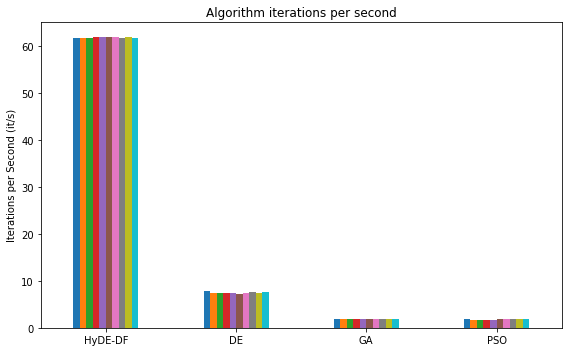

In [38]:
# Plot the execution times

(df_it / df_times).transpose().plot(kind='bar', legend=None, figsize=(8, 5))
plt.xticks(rotation=0)

plt.title('Algorithm iterations per second')
plt.ylabel('Iterations per Second (it/s)')

plt.tight_layout()

plt.show()

In [39]:
# Print the iterations per second

df_it / df_times

,HyDE-DF,DE,GA,PSO
0,61.723972,7.846204,1.959166,1.771212
1,61.695207,7.492364,1.941572,1.767831
2,61.727627,7.330425,1.968435,1.751933
3,61.953522,7.452886,1.980594,1.741444
4,61.850051,7.434245,1.962022,1.749709
5,61.860267,7.298966,1.956875,1.784588
6,61.869713,7.310375,1.968943,1.775707
7,61.811864,7.594593,1.950548,1.794106
8,61.860232,7.468126,1.914474,1.817454
9,61.807896,7.579468,1.965062,1.801890


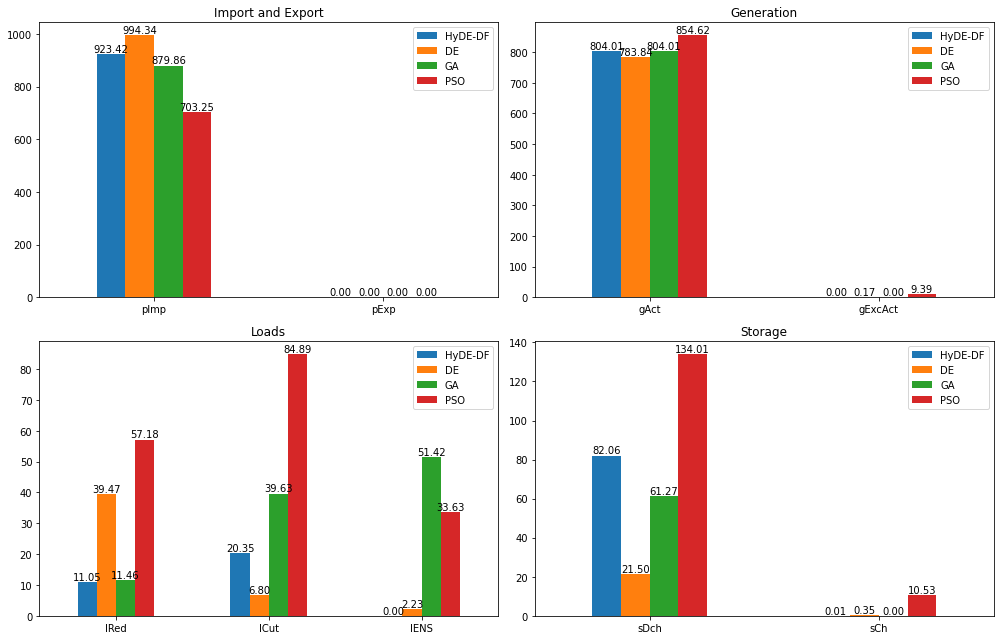

In [47]:
# Gather the sum data into a single dataframe

temp_keys = ['pImp', 'pExp', 'genActPower', 'genExcActPower', 'loadRedActPower', 'loadCutActPower', 'loadENS', 
             'storDchActPower', 'storChActPower', 'csActPowerNet', 'v2gDchActPower']

temp_cols = ['pImp', 'pExp', 'gAct', 'gExcAct', 'lRed', 'lCut', 'lENS', 
             'sDch', 'sCh', 'cs', 'v2gDch']

aggregated_sums = pd.DataFrame({'HyDE-DF': [np.sum(np.sum(results_hyde['run04'][key])) for key in temp_keys],
                                'DE': [np.sum(np.sum(decoded_de['run02'][key])) for key in temp_keys],
                                'GA': [np.sum(np.sum(decoded_ga['run05'][key])) for key in temp_keys],
                                'PSO': [np.sum(np.sum(decoded_pso['run04'][key])) for key in temp_keys]}, 
                               index=temp_cols)

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(14, 9))
bars1 = aggregated_sums.transpose()[['pImp', 'pExp']].transpose().plot(kind='bar', ax=axs[0, 0])
bars2 = aggregated_sums.transpose()[['gAct', 'gExcAct']].transpose().plot(kind='bar', ax=axs[0, 1])
bars3 = aggregated_sums.transpose()[['lRed', 'lCut', 'lENS']].transpose().plot(kind='bar', ax=axs[1, 0])
bars4 = aggregated_sums.transpose()[['sDch', 'sCh']].transpose().plot(kind='bar', ax=axs[1, 1])
#aggregated_sums.transpose()[['cs', 'v2gDch']].transpose().plot(kind='bar', ax=axs[0, 2])

axs[0, 0].set_title('Import and Export')
axs[0, 0].set_xticklabels(['pImp', 'pExp'], rotation=0)
for p in bars1.containers:
    bars1.bar_label(p, fmt='%.2f', label_type='edge')

axs[0, 1].set_title('Generation')
axs[0, 1].set_xticklabels(['gAct', 'gExcAct'], rotation=0)
for p in bars2.containers:
    bars2.bar_label(p, fmt='%.2f', label_type='edge')

axs[1, 0].set_title('Loads')
axs[1, 0].set_xticklabels(['lRed', 'lCut', 'lENS'], rotation=0)
for p in bars3.containers:
    bars3.bar_label(p, fmt='%.2f', label_type='edge')

axs[1, 1].set_title('Storage')
axs[1, 1].set_xticklabels(['sDch', 'sCh'], rotation=0)
for p in bars4.containers:
    bars4.bar_label(p, fmt='%.2f', label_type='edge')

plt.tight_layout()

plt.show()

In [40]:
## Get the objective function values aggregated

df_objFn = pd.DataFrame({'HyDE-DF': [results_hyde['run{:02d}'.format(i)]['overall']['Fit'].values[0]
                                     for i in np.arange(1, 11)],
                         'DE': [results_de['run{:02d}'.format(i)]['stats']['objFun'].values[0]
                                for i in np.arange(1, 11)],
                         'GA': [results_ga['run{:02d}'.format(i)]['stats']['objFun'].values[0]
                                for i in np.arange(1, 11)],
                         'PSO': [results_pso['run{:02d}'.format(i)]['stats']['objFun'].values[0]
                                 for i in np.arange(1, 11)]})

In [41]:
df_objFn.round(2)

,HyDE-DF,DE,GA,PSO
0,190.60,273.58,432.19,734.78
1,170.59,184.74,426.14,664.04
2,193.55,189.55,695.50,863.56
3,165.93,336.52,474.96,413.82
4,235.73,236.24,407.53,611.67
5,170.90,186.49,444.28,688.96
6,181.57,197.71,422.13,662.74
7,175.99,198.62,473.71,720.61
8,184.76,188.05,470.83,848.23
9,188.95,242.03,607.93,652.94


In [50]:
df_objFn.describe().round(2)

,HyDE-DF,DE,GA,PSO
count,10.00,10.00,10.00,10.00
mean,185.86,223.35,485.52,686.13
std,19.86,49.84,92.92,126.12
min,165.93,184.74,407.53,413.82
25%,172.17,188.42,427.65,655.39
50%,183.16,198.17,457.56,676.50
75%,190.19,240.58,474.65,731.24
max,235.73,336.52,695.50,863.56


In [43]:
df_times

,HyDE-DF,DE,GA,PSO
0,810.058037,2021.869460,4575.415510,28229.258083
1,810.435724,1411.036544,6622.982381,28283.245109
2,810.010081,2349.658970,5351.966712,28539.902729
3,807.056624,1450.981472,4324.460225,28711.798129
4,808.406766,1886.405310,4822.067325,28576.180799
5,808.273269,2378.007996,5325.327495,28017.674382
6,808.149868,2390.848585,4931.072185,28157.800941
7,808.906205,1141.206629,5084.212228,27869.036303
8,808.273724,1737.249851,6438.321763,27511.018401
9,808.958129,1309.854525,4764.225087,27748.643154


In [44]:
df_it.describe().round(2)

,HyDE-DF,DE,GA,PSO
count,10.0,10.0,10.00,10.0
mean,50000.0,13490.2,10211.90,50000.0
std,0.0,3376.6,1395.24,0.0
min,50000.0,8667.0,8565.00,50000.0
25%,50000.0,10632.5,9386.75,50000.0
50%,50000.0,13499.0,9813.00,50000.0
75%,50000.0,16884.0,10506.50,50000.0
max,50000.0,17478.0,12859.00,50000.0


In [45]:
# Aggregate the consumption and production of the solutions -  HyDE-DF

# Consumption:
# - loads
# - battery charging
# - energy exports

# Productions:
# - generators
# - battery discharging
# - energy imports

# Consumption:

HYDE_RUN = 'run04'

df_hyde_cons = pd.DataFrame({'loadActPower': np.sum(results_hyde[HYDE_RUN]['loadActPower'], axis=0),
                             'genExcActPower': np.sum(results_hyde[HYDE_RUN]['genExcActPower'], axis=0),
                             'csActPower': np.sum(results_hyde[HYDE_RUN]['csActPower'], axis=0),
                             'pExp': results_hyde[HYDE_RUN]['pExp'].values.ravel(),
                             'storChActPower': np.sum(results_hyde[HYDE_RUN]['storChActPower'], axis=0)})
df_hyde_cons.index = ['{:02d}:00'.format(i) for i in np.arange(24)]

df_hyde_prod = pd.DataFrame({'genAcPower': np.sum(results_hyde[HYDE_RUN]['genActPower'], axis=0),
                             'pImp': results_hyde[HYDE_RUN]['pImp'].values.ravel(),
                             'storDchActPower': np.sum(results_hyde[HYDE_RUN]['storDchActPower'], axis=0),
                             'v2gDchActPower': np.sum(results_hyde[HYDE_RUN]['v2gDchActPower'], axis=0),
                             'loadCutActPower': np.sum(results_hyde[HYDE_RUN]['loadCutActPower'], axis=0),
                             'loadRedActPower': np.sum(results_hyde[HYDE_RUN]['loadRedActPower'], axis=0),
                             'loadENS': np.sum(results_hyde[HYDE_RUN]['loadENS'], axis=0)})
df_hyde_prod.index = ['{:02d}:00'.format(i) for i in np.arange(24)]

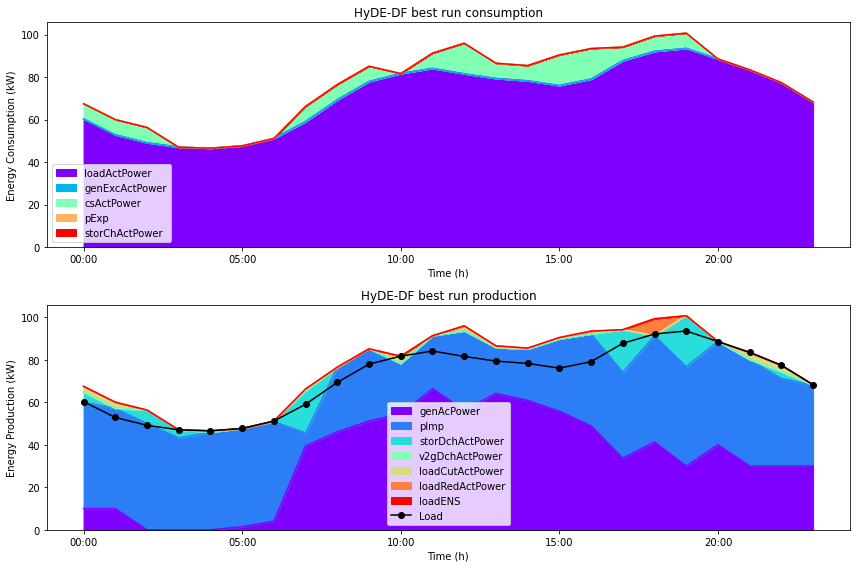

In [46]:
# HyDE-DF best run results for consumption and production

fig, axs = plt.subplots(nrows=2, figsize=(12, 8))

df_hyde_cons.plot.area(ax=axs[0], cmap='rainbow')
axs[0].set_title('HyDE-DF best run consumption')
axs[0].set_ylabel('Energy Consumption (kW)')
axs[0].set_xlabel('Time (h)')

df_hyde_prod.plot.area(ax=axs[1], cmap='rainbow')
axs[1].plot(np.sum(results_hyde['run04']['loadActPower'], axis=0), 'o-', label='Load', color='black')
axs[1].legend()
axs[1].set_title('HyDE-DF best run production')
axs[1].set_ylabel('Energy Production (kW)')
axs[1].set_xlabel('Time (h)')

plt.tight_layout()

plt.show()

In [34]:
# Aggregate the consumption and production of the solutions -  DE

# Consumption:
# - loads
# - battery charging
# - energy exports
# - genExc

# Productions:
# - generators
# - battery discharging
# - energy imports

# Consumption:

de_run = 'run02'

df_de_cons = pd.DataFrame({'loadActPower': np.sum(results_hyde['run05']['loadActPower'], axis=0),
                           'genExcActPower': np.sum(decoded_de[de_run]['genExcActPower'], axis=0),
                           'csActPower': np.sum(decoded_de[de_run]['csActPower'], axis=0),
                           'pExp': decoded_de[de_run]['pExp'],
                           'storChActPower': np.sum(decoded_de[de_run]['storChActPower'], axis=0)})
df_de_cons.index = ['{:02d}:00'.format(i) for i in np.arange(24)]

df_de_prod = pd.DataFrame({'genAcPower': np.sum(decoded_de[de_run]['genActPower'], axis=0),
                           'pImp': decoded_de[de_run]['pImp'],
                           'storDchActPower': np.sum(decoded_de[de_run]['storDchActPower'], axis=0),
                           'v2gDchActPower': np.sum(decoded_de[de_run]['v2gDchActPower'], axis=0),
                           'loadCutActPower': np.sum(decoded_de[de_run]['loadCutActPower'], axis=0),
                           'loadRedActPower': np.sum(decoded_de[de_run]['loadRedActPower'], axis=0),
                           'loadENS': np.sum(decoded_de[de_run]['loadENS'], axis=0)})
df_de_prod.index = ['{:02d}:00'.format(i) for i in np.arange(24)]

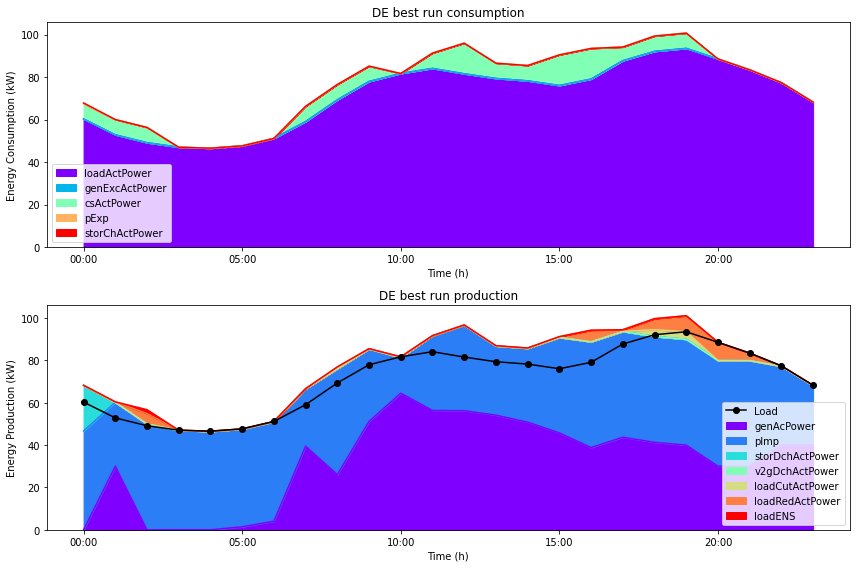

In [116]:
# DE best run results for consumption and production

fig, axs = plt.subplots(nrows=2, figsize=(12, 8))

df_de_cons.plot.area(ax=axs[0], cmap='rainbow')
axs[0].set_title('DE best run consumption')
axs[0].set_ylabel('Energy Consumption (kW)')
axs[0].set_xlabel('Time (h)')

df_de_prod.plot.area(ax=axs[1], cmap='rainbow')
axs[1].plot(np.sum(results_hyde['run04']['loadActPower'], axis=0), 'o-', label='Load', color='black')
axs[1].legend()
axs[1].set_title('DE best run production')
axs[1].set_ylabel('Energy Production (kW)')
axs[1].set_xlabel('Time (h)')

plt.tight_layout()

plt.show()

In [54]:
# Aggregate the consumption and production of the solutions -  GA

# Consumption:
# - loads
# - battery charging
# - energy exports
# - genExc

# Productions:
# - generators
# - battery discharging
# - energy imports

# Consumption:

pso_run = 'run04'

df_pso_cons = pd.DataFrame({'loadActPower': np.sum(results_hyde[pso_run]['loadActPower'], axis=0),
                            'genExcActPower': np.sum(decoded_pso[pso_run]['genExcActPower'], axis=0),
                            'csActPower': np.sum(decoded_pso[pso_run]['csActPower'], axis=0),
                            'pExp': decoded_pso[pso_run]['pExp'],
                            'storChActPower': np.sum(decoded_pso[pso_run]['storChActPower'], axis=0)})
df_pso_cons.index = ['{:02d}:00'.format(i) for i in np.arange(24)]

df_pso_prod = pd.DataFrame({'genAcPower': np.sum(decoded_pso[pso_run]['genActPower'], axis=0),
                            'pImp': decoded_pso[pso_run]['pImp'],
                            'storDchActPower': np.sum(decoded_pso[pso_run]['storDchActPower'], axis=0),
                            'v2gDchActPower': np.sum(decoded_pso[pso_run]['v2gDchActPower'], axis=0),
                            'loadCutActPower': np.sum(decoded_pso[pso_run]['loadCutActPower'], axis=0),
                            'loadRedActPower': np.sum(decoded_pso[pso_run]['loadRedActPower'], axis=0),
                            'loadENS': np.sum(decoded_pso[pso_run]['loadENS'], axis=0)})
df_pso_prod.index = ['{:02d}:00'.format(i) for i in np.arange(24)]

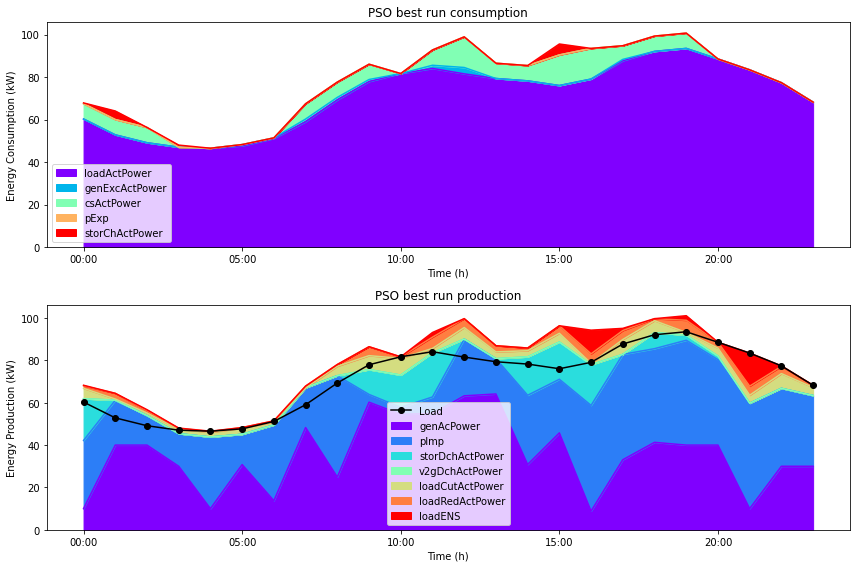

In [117]:
# PSO best run results for consumption and production

fig, axs = plt.subplots(nrows=2, figsize=(12, 8))

df_pso_cons.plot.area(ax=axs[0], cmap='rainbow')
axs[0].set_title('PSO best run consumption')
axs[0].set_ylabel('Energy Consumption (kW)')
axs[0].set_xlabel('Time (h)')

df_pso_prod.plot.area(ax=axs[1], cmap='rainbow')
axs[1].plot(np.sum(results_hyde['run04']['loadActPower'], axis=0), 'o-', label='Load', color='black')
axs[1].legend()
axs[1].set_title('PSO best run production')
axs[1].set_ylabel('Energy Production (kW)')
axs[1].set_xlabel('Time (h)')

plt.tight_layout()

plt.show()